# Exciton in a Cavity: Polaritons 

A [polariton](https://en.wikipedia.org/wiki/Polariton) is a quasi-particle that forms due to the interaction between an optical mode and an exciton. Polaritons are light-matter hybrids that can exhibit a mixture of properties typical of photons and excitons.

Here, we will study the dynamics of an exciton-polariton system given by a monochromatic cavity coupled to a molecule's optical excited state. The molecule also has a dark triplet state that can be populated via [intersystem crossing](https://en.wikipedia.org/wiki/Intersystem_crossing) (ISC).

## Import modules and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from diagnostics import density_matrix_positivity, trajectory_min_eigs
from plotting import style, plot_min_eig, plot_coherences, plot_populations
style()

## Cavity Hamiltonian

A monochromatic cavity mode is a quantum harmonic oscillator with frequency $\omega_c$:

$H_c = \omega_c \hat{a}^\dagger \hat{a} = \omega_c \hat{n}$,

where $\hat{n}$ is the number operator and $\hat{a}^\dagger$ the creation operator of the cavity.

Construct the cavity Hamiltonian truncating the space of states to a maximum number of excitations $n_\mathrm{max}=3$, and a frequency $\omega_c = 1$.

Then, construct the creation and annihilation operators using the following definition:
\begin{aligned}\hat{a}^{\dagger }|n\rangle &={\sqrt {n+1}}|n+1\rangle \\ \hat{a}|n\rangle &={\sqrt {n}}|n-1\rangle .\end{aligned},
and testing that $\hat{a}^\dagger \hat{a} = \hat{n}$.

In [2]:
# maximum occupation number
nmax = 3

# cavity frequency
wc = 1

# cavity Hamiltonian
Hc = wc * qt.num(nmax+1)

# creation operator
a = qt.destroy(nmax+1)

# test a.dag() * a == qt.num(nmax+1)
print((a.dag() * a).full()[:4,:4])  # show first 4x4

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 3.+0.j]]


## Exciton Hamiltonian

The exciton Hamiltonian is composed of the ground ($S_0$), optically excited ($S_1$) and dark excited ($T_1$) states, which have energies $0$, $\varepsilon_S$ and $\varepsilon_T$, respectively:

$ H_e = \varepsilon_S |S_1\rangle\langle S_1| + \varepsilon_T |T_1\rangle\langle T_1|$.

Construct the exciton Hamiltonian for $\varepsilon_S = 1$ and $\varepsilon_T = 0.5 \varepsilon_S$. The construct the exciton creation operators:

- $S^\dagger = |S_1\rangle\langle S_0|$
- $T^\dagger = |T_1\rangle\langle S_0|$

In [3]:
# singlet energy
eS = 1

# triplet energy
eT = 0.5 * eS

# exciton basis
S0 = qt.basis(3, 0)
S1 = qt.basis(3, 1)
T1 = qt.basis(3, 2)

# exciton Hamiltonian
He = qt.Qobj(np.diag([0, eS, eT]))

# annihilation operators
S = S0 * S1.dag()
T = S0 * T1.dag()

## Exciton-photon coupling and polariton Hamiltonian

The interaction $V$ between the cavity and the atom is described by the atom-field dipolar interaction (Dicke model), which reads:

$V = g (\hat{a}^\dagger + \hat{a})\otimes (S^\dagger + S)$.

This leads to the total Hamiltonian:

$H = H_c\otimes \mathbb{1} + \mathbb{1}\otimes H_e + V$.

However, if the ration between the coupling strength $g$ and the cavity frequency $\omega_c$ is small, $g/\omega_c \ll 1$, we can perform the rotating wave approximation (RWA), and replace $V$ with the following interaction:

$V \to V_\mathrm{RWA} = g (\hat{a}\otimes S^\dagger + \hat{a}^\dagger\otimes S)$

Construct the total Hamiltonian for $g=0.001$, testing if the RWA is respected by checking that $g/\omega_c < 0.01$.

In [4]:
# function to get the total Hamiltonian
def Hamiltonian(wc=1, eS=1, eT=0.5, g=0, nmax=3, RWA_test=0.01, printing=True):
    
    # cavity Hamiltonian
    Hc = wc * qt.num(nmax+1)
    
    # exciton Hamiltonian
    He = qt.Qobj(np.diag([0, eS, eT]))
    
    # annihilation operators
    S0 = qt.basis(3, 0)
    S1 = qt.basis(3, 1)
    T1 = qt.basis(3, 2)
    S = S0 * S1.dag()
    T = S0 * T1.dag()

    # RWA test
    RWA = (g/wc < RWA_test)
    if printing:
        print('RWA is', RWA)

    if RWA:
        V = g * (qt.tensor(qt.destroy(nmax+1), S.dag()) + qt.tensor(qt.create(nmax+1), S))
    else:
        V = g * qt.tensor(qt.destroy(nmax+1) + qt.create(nmax+1), S.dag() + S)

    H = qt.tensor(Hc, qt.qeye(3)) + qt.tensor(qt.qeye(nmax+1), He) + V
    
    return H

# coupling strength
g = 0.001

# construct Hamiltonian
H = Hamiltonian(wc=wc, eS=eS, eT=eT, g=g, nmax=4)
H

RWA is True


Quantum object: dims=[[5, 3], [5, 3]], shape=(15, 15), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.00000000e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-03 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000

## Polariton dispersion relation and hybrid character

Let us consider a cavity with the following dispersion relation:
$\omega_c(\theta) =  \frac{\omega_0 }{\sqrt{1 - \sin^2(t)}}$.

Calculate the eigenvalues $\varepsilon_k$ of the total Hamiltonian $H$ as a function of $\theta$ for $\omega_0=0.8$, choosing $n_\mathrm{max} = 1$ and $g = 0.1$. Compare them to the eigenvalues of the non-interacting ($g=0$) system Hamiltonian $H_0 = H|_{g=0}$.

To calculate and sort the eigenvectors you can use `eigensorter` from `tools`.

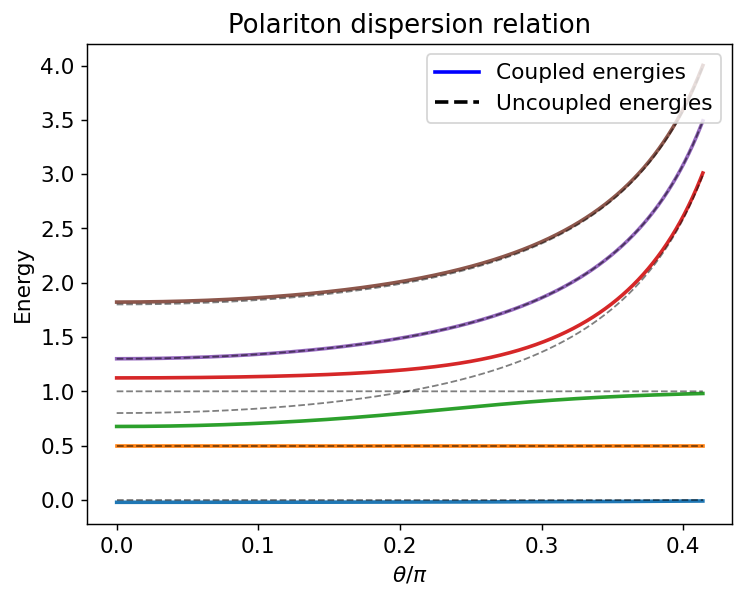

In [5]:
# dispersion relation of the cavity
energy_cavity = lambda th, w0=1: w0*(1-np.sin(th)**2)**(-1/2)

# angles
ths = np.linspace(0,1.3,1000)

# max occupation
nmax = 1

# interaction strength
g = 0.2

# cavity base frequency
w0 = 0.8

# eigenvalues datasets
data = []
data0 = []

# loop over angles
for th in ths:
    # cavity energy
    wc = energy_cavity(th, w0=w0)
    # construct Hamiltonian
    H = Hamiltonian(wc=wc, eS=eS, eT=eT, g=g, nmax=nmax, printing=False)
    # calculate the eigenvalues
    evals = H.eigenenergies()
    data.append(np.sort(evals))
    # construct non-interacting Hamiltonian
    H0 = Hamiltonian(wc=wc, eS=eS, eT=eT, g=0, nmax=nmax, printing=False)
    # calculate the eigenvalues
    evals0 = H0.eigenenergies()
    data0.append(np.sort(evals0))

# organise data
data = np.array(data).T
data0 = np.array(data0).T

# figure
fig, ax = plt.subplots()

for k in range(len(data)):
    ax.plot(ths/np.pi, data[k])
    ax.plot(ths/np.pi, data0[k], 'k--', lw=1, alpha=0.5)

# add labels
ax.set_xlabel(r'$\theta / \pi$')
ax.set_ylabel('Energy')
ax.set_title('Polariton dispersion relation')

# add legend
solid_line = plt.Line2D([0], [0], color='blue', linestyle='-', label='Coupled energies')
dashed_line = plt.Line2D([0], [0], color='black', linestyle='--', label='Uncoupled energies')
ax.legend(handles=[solid_line, dashed_line], loc='upper right')

## Single excitation manifold

The single excitation manifold is composed of the states that contain at most one excitation:

- 1-photon state: $|\text{photon}\rangle = |1\rangle\otimes|S_0\rangle$
- 1-singlet state: $|\text{singlet}\rangle =|0\rangle\otimes|S_1\rangle$
- 1-triplet state: $|\text{triplet}\rangle =|0\rangle\otimes|T_1\rangle$

where $|n\rangle$ is the cavity state with $n$ photons.

Construct the single excitation manifold states and write a function to measure their population $p_\phi$ for any considered state $\rho$, i.e.,

- $p_\phi = \mathrm{Tr}[\rho |\phi\rangle\langle\phi|]$

Then, use this function to study the hybridisation of the eigenstates of the Hamiltonian as a function of the $\theta$.

**Note**: Choose $n_\mathrm{max} = 1$ to simplify calculations.

Text(0.02, 0.98, 'Point opacity indicates\ncharacter admixture')

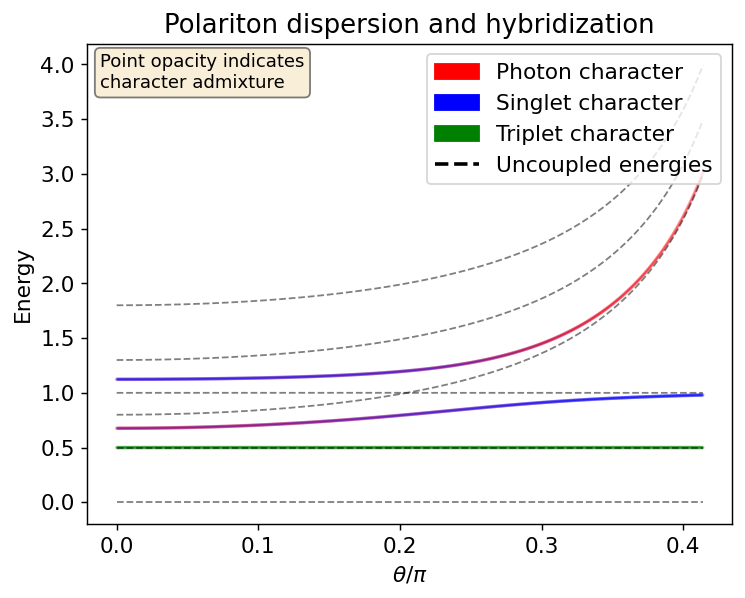

In [6]:
# nmax
nmax = 1

# cavity states
n0 = qt.basis(nmax+1, 0)
n1 = qt.basis(nmax+1, 1)

# single excitation states
triplet = qt.tensor(n0, T1)
singlet = qt.tensor(n0, S1)
photon = qt.tensor(n1, S0)

# character
def character(rho, character=triplet):
    # character operator
    O = character * character.dag()
    # measure population of character
    pop = qt.expect(O, rho)
    # return
    return pop

# results 
data = []
chars = []

# loop over angles
for th in ths:
    # cavity energy
    wc = energy_cavity(th, w0=w0)
    # construct Hamiltonian
    H = Hamiltonian(wc=wc, eS=eS, eT=eT, g=g, nmax=nmax, RWA_test=1, printing=False)
    # calculate the eigenvalues
    evals, ekets = H.eigenstates()
    data.append(np.sort(evals))
    # measure character
    p1 = [character(qt.ket2dm(ket), photon) for ket in ekets] 
    s1 = [character(qt.ket2dm(ket), singlet) for ket in ekets] 
    t1 = [character(qt.ket2dm(ket), triplet) for ket in ekets] 
    # append characters
    chars.append([p1, s1, t1])

# organise data
data = np.array(data).T
chars = np.array(chars).T

# figure
fig, ax = plt.subplots()

for k in range(len(data)):
    # plot cavity (red)
    ax.scatter(ths/np.pi, data[k], c='r', s=1, alpha=0.2*chars[k][0])
    # plot singlet character (blue)
    ax.scatter(ths/np.pi, data[k], c='b', s=1, alpha=0.2*chars[k][1])
    # plot triplets character (green)
    ax.scatter(ths/np.pi, data[k], c='g', s=1, alpha=0.2*chars[k][2])
    # plot non-interacting eigenvalues
    ax.plot(ths/np.pi, data0[k], 'k--', lw=1, alpha=0.5)

# add labels and legend
ax.set_xlabel(r'$\theta / \pi$')
ax.set_ylabel('Energy')
ax.set_title('Polariton dispersion and hybridization')

# add legend with proxy artists
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Photon character')
blue_patch = mpatches.Patch(color='blue', label='Singlet character')
green_patch = mpatches.Patch(color='green', label='Triplet character')
black_line = plt.Line2D([0], [0], color='black', linestyle='--', label='Uncoupled energies')
ax.legend(handles=[red_patch, blue_patch, green_patch, black_line], loc='upper right')

# add text explanation
ax.text(0.02, 0.98, 'Point opacity indicates\ncharacter admixture', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

## Dynamics

We now consider a laser pumping the system with a frequency in resonance with the cavity $\omega_p = \omega_c$ and study the evolution of the polariton generated by the total Hamiltonian $H_\mathrm{tot} = H + H_p$ where $H_p$ is the laser pump Hamiltonian, and the Lindblad operators associated with incoherent transitions:

1. Total Hamiltonian in the rotating frame with frequency $\omega_p$ and amplitude $J$:
    - $H_\mathrm{tot} = H + H_p$
    - $H_p= \sum_k \bigg[ J\Big(|\varphi_k\rangle\langle \text{vac}| + h.c.\Big) -\omega_p |\varphi_k\rangle\langle \varphi_k| \bigg]$,
  
where $|\varphi_k\rangle = \{ |1\rangle\otimes|S_0\rangle, |0\rangle\otimes|S_1\rangle, |1\rangle\otimes|S_1\rangle \}$ are the *bright* states that couple with the laser pump field, and $|\text{va}\rangle = |0\rangle\otimes|S_0\rangle$ is the vacuum state.
      
2. Lindblad operators for:
    - Cavity loss (photon emission) $\sqrt{\gamma_c}\:a\otimes\mathbb{1}$
    - Singlet radiative emission $\sqrt{\gamma_S}\: \mathbb{1}\otimes S$
    - Triplet recombination $\sqrt{\gamma_T} \: \mathbb{1}\otimes  T$
    - Intersystem crossing $\sqrt{\gamma_{ISC}}\:\mathbb{1}\otimes  T^\dagger S$
  
Use the following parameters:

- $\psi_0 = |\text{vac}\rangle  = |0\rangle\otimes|S_0\rangle $
- $J = 1$
- $w_c = 0.8$
- $w_p = w_c$
- $g = 0.1$
- $n_\mathrm{max} = 1$ 
- $\varepsilon_S =1$
- $\varepsilon_T =0.5$
- $\gamma_c = 0.1$
- $\gamma_s = 0.1$
- $\gamma_t = 0.001$
- $\gamma_\mathrm{ISC} = 0.01$

In [7]:
# pump amplitude
J = 1

# cavity frequency
wc = 0.8

# exciton energies
eS, eT = 1, 0.5

# pump frequency
wp = wc

# coupling
g = 0.1

# max occupation number
nmax = 1

# Hamiltonian
H = Hamiltonian(wc=wc, eS=eS, eT=eT, g=g, nmax=nmax, RWA_test=0)

# eigenstates
evals, ekets = H.eigenstates()

# vacuum state
vac = qt.tensor(n0, S0)

# select the bright states
bright_states = [qt.tensor(n0, S1), qt.tensor(n1, S0), qt.tensor(n1, S1)]

# pumping Hamiltonian
Hp = (sum([-wp * qt.ket2dm(bs) for bs in bright_states])
      + sum([J * (vac * bs.dag() + bs * vac.dag()) for bs in bright_states]))

# total hamiltonian
Htot = H + Hp

# Decoherence rates
gc = 0.1
gs = 0.1
gt = 0.001
gISC = 0.01

# Lindblad operators
c_ops = [np.sqrt(gc) * qt.tensor(qt.destroy(nmax+1), qt.qeye(3)),
         np.sqrt(gs) * qt.tensor(qt.qeye(nmax+1), S),
         np.sqrt(gt) * qt.tensor(qt.qeye(nmax+1), T),
         np.sqrt(gISC) * qt.tensor(qt.qeye(nmax+1), T.dag() * S)]

# final time
tf = 30

# times
times = np.linspace(0, tf, 3000)

# initial state
rho0 = qt.ket2dm(vac)

# e_ops
photon_op = qt.ket2dm(photon)
singlet_op = qt.ket2dm(singlet)
triplet_op = qt.ket2dm(triplet)

# solve
res_me = qt.mesolve(H=Htot, rho0=rho0, tlist=times, c_ops=c_ops, e_ops=[photon_op, singlet_op, triplet_op], options={"store_states": True})


# baths for brmesolve
bath = qt.OhmicEnvironment(T=1e-3, wc=10*wc, alpha=0.0001, s=1)

# a_ops
a_ops = [[0.1 * qt.tensor(qt.destroy(nmax+1), qt.qeye(3)), bath],
         [0.1 * qt.tensor(qt.qeye(nmax+1), S), bath],
         [0.001 * qt.tensor(qt.qeye(nmax+1), T), bath],
         [0.01 * qt.tensor(qt.qeye(nmax+1), T.dag() * S), bath]]

# solve with brmesolve
res_br = qt.brmesolve(H=Htot, psi0=rho0, tlist=times, a_ops=a_ops, e_ops=[photon_op, singlet_op, triplet_op], options={"store_states": True}, sec_cutoff=-1)
res_br_s = qt.brmesolve(H=Htot, psi0=rho0, tlist=times, a_ops=a_ops, e_ops=[photon_op, singlet_op, triplet_op], options={"store_states": True}, sec_cutoff=0.0)

RWA is False


c:\Users\leopo\anaconda3\envs\redfield\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


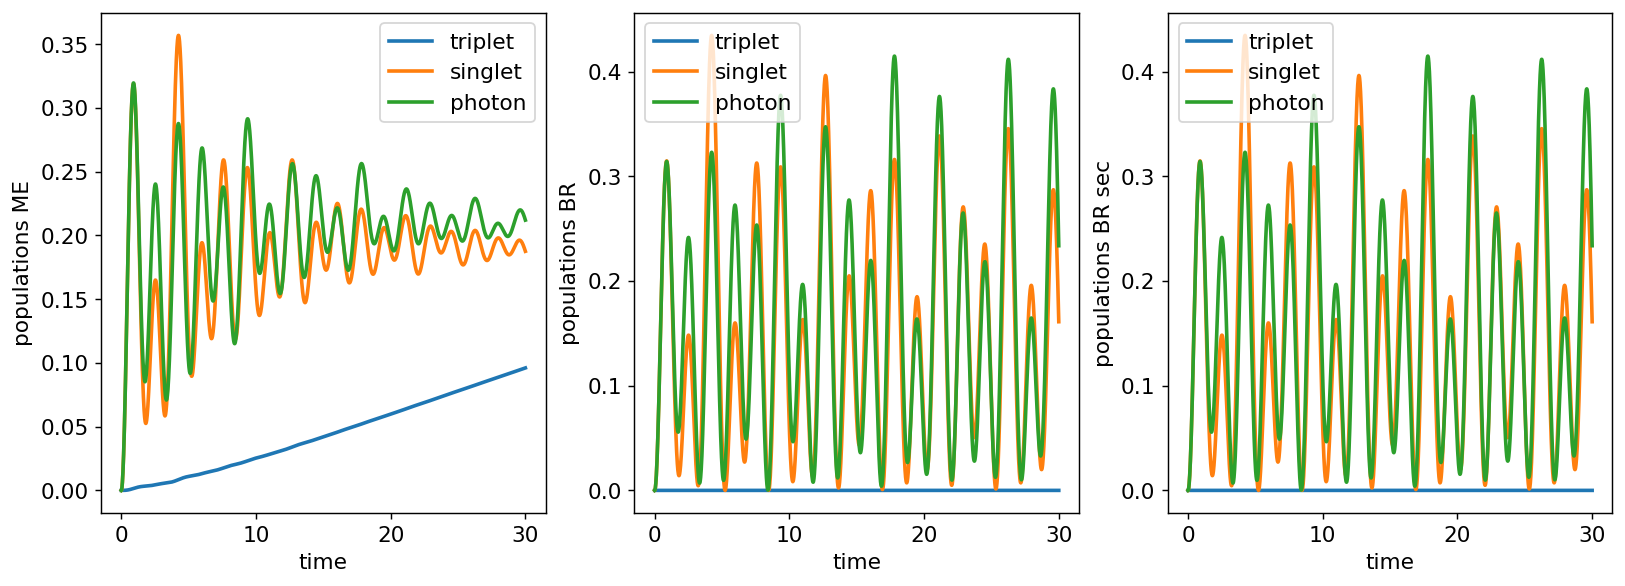

In [8]:
# extract expectations
pP = res_me.expect[0]
pS = res_me.expect[1]
pT = res_me.expect[2]

pP_br = res_br.expect[0]
pS_br = res_br.expect[1]
pT_br = res_br.expect[2]

pP_br_s = res_br_s.expect[0]
pS_br_s = res_br_s.expect[1]
pT_br_s = res_br_s.expect[2]


# plot populations comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(times, pT, label='triplet')
ax1.plot(times, pS, label='singlet')
ax1.plot(times, pP, label='photon')
ax1.set_xlabel('time')
ax1.set_ylabel('populations ME')
ax1.legend()

ax2.plot(times, pT_br, label='triplet')
ax2.plot(times, pS_br, label='singlet')
ax2.plot(times, pP_br, label='photon')
ax2.set_xlabel('time')
ax2.set_ylabel('populations BR')
ax2.legend()

ax3.plot(times, pT_br_s, label='triplet')
ax3.plot(times, pS_br_s, label='singlet')
ax3.plot(times, pP_br_s, label='photon')
ax3.set_xlabel('time')
ax3.set_ylabel('populations BR sec')
ax3.legend()

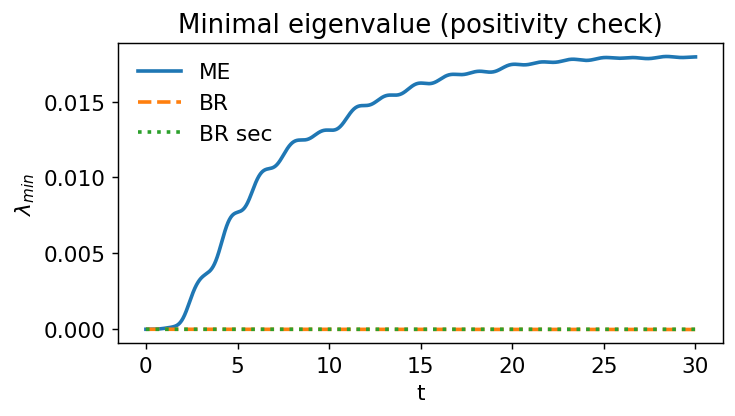

In [9]:
# minimal eigenvalues for positivity check
from diagnostics import trajectory_min_eigs

min_eigs_me = trajectory_min_eigs(res_me.states)
min_eigs_br = trajectory_min_eigs(res_br.states)
min_eigs_br_s = trajectory_min_eigs(res_br_s.states)

plt.figure(figsize=(6,3))
plt.plot(times, min_eigs_me, label='ME', ls='-')
plt.plot(times, min_eigs_br, label='BR', ls='--')
plt.plot(times, min_eigs_br_s, label='BR sec', ls=':')
plt.ylabel(r'$\lambda_{min}$')
plt.xlabel('t')
plt.legend(frameon=False)
plt.title('Minimal eigenvalue (positivity check)')
plt.show()

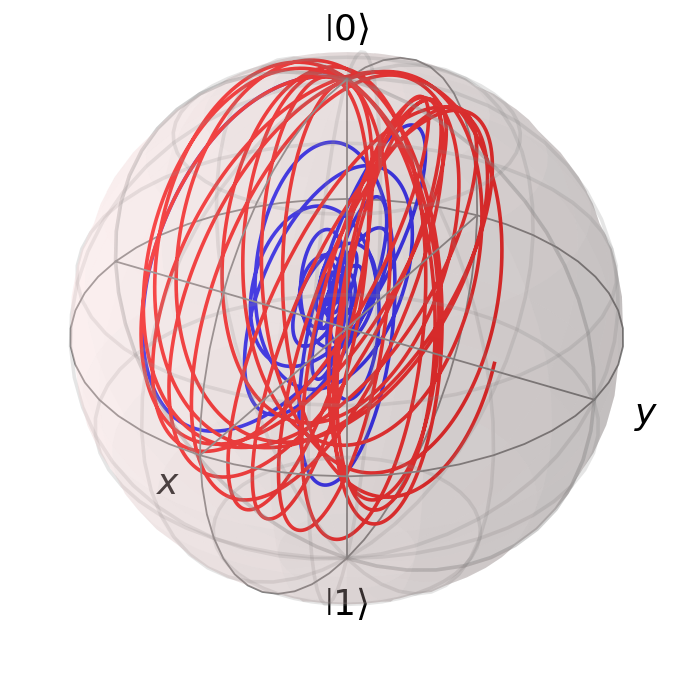

In [10]:
# Plot the evolution of the cavity's reduced state on the Bloch sphere
# The cavity is treated as a 2-level system (truncated to nmax=1)

# Reduced states of the cavity (index 0 in tensor)
cavity_states_me = [qt.ptrace(state, 0) for state in res_me.states]
cavity_states_br = [qt.ptrace(state, 0) for state in res_br.states]
cavity_states_br_s = [qt.ptrace(state, 0) for state in res_br.states]

# Bloch vectors for ME
bloch_vectors_cavity_me = np.real(np.array([[qt.expect(qt.sigmax(), rho), qt.expect(qt.sigmay(), rho), qt.expect(qt.sigmaz(), rho)] for rho in cavity_states_me]))
bloch_vectors_cavity_br = np.real(np.array([[qt.expect(qt.sigmax(), rho), qt.expect(qt.sigmay(), rho), qt.expect(qt.sigmaz(), rho)] for rho in cavity_states_br]))
bloch_vectors_cavity_br_s = np.real(np.array([[qt.expect(qt.sigmax(), rho), qt.expect(qt.sigmay(), rho), qt.expect(qt.sigmaz(), rho)] for rho in cavity_states_br_s]))

# Bloch sphere
b = qt.Bloch()
b.add_points(bloch_vectors_cavity_me.T, 'l')
#b.add_points(bloch_vectors_cavity_br.T, 'l')
b.add_points(bloch_vectors_cavity_br_s.T, 'l')
b.show()